# Working with Instrumental Descriptions

the instrumental description is loaded by the event source, and consists of a hierarchy of classes in the ctapipe.instrument module, the base of which is the `SubarrayDescription`

First, let's open a file and load a single event so we get the instrument info in the event.inst container.

In [1]:
from ctapipe.utils.datasets import get_dataset_path
from ctapipe.io import event_source
import numpy as np

#filename = get_dataset_path("gamma_test_large.simtel.gz") # try this one as well
filename = get_dataset_path("gamma_test_large.simtel.gz")  

# just get the first event in the file:
with event_source(filename, max_events=1) as source:
    event = next(iter(source))


## the SubarrayDescription:

In [2]:
subarray = event.inst.subarray

subarray.info()

Subarray : MonteCarloArray
Num Tels : 98
Footprint: 4.92 km2

                TYPE  Num IDmin  IDmax
      LST_LST_LSTCam    4    1 ..   4
    MST_MST_FlashCam   25    5 ..  29
  SST_ASTRI_ASTRICam   69   30 ..  98


In [3]:
subarray.to_table()

tel_id,pos_x,pos_y,pos_z,name,type,num_mirrors,camera_type,tel_description
,m,m,m,,,,,
int16,float64,float64,float64,str5,str3,int64,str8,str18
1,-20.0,65.0,16.0,LST,LST,1,LSTCam,LST_LST_LSTCam
2,-20.0,-65.0,16.0,LST,LST,1,LSTCam,LST_LST_LSTCam
3,80.0,0.0,16.0,LST,LST,1,LSTCam,LST_LST_LSTCam
4,-120.0,0.0,16.0,LST,LST,1,LSTCam,LST_LST_LSTCam
5,0.0,0.0,10.0,MST,MST,1,FlashCam,MST_MST_FlashCam
6,0.0,151.1999969482422,10.0,MST,MST,1,FlashCam,MST_MST_FlashCam
7,0.0,-151.1999969482422,10.0,MST,MST,1,FlashCam,MST_MST_FlashCam
8,146.65599060058594,75.5999984741211,10.0,MST,MST,1,FlashCam,MST_MST_FlashCam


You can also get a table of just the `OpticsDescriptions` (`CameraGeometry` is more complex and can't be stored on a single table row, so each one can be converted to a table separately)

In [4]:
subarray.to_table(kind='optics')

description,name,type,mirror_area,num_mirrors,num_mirror_tiles,equivalent_focal_length
,,,m2,,,m
str18,str5,str3,float64,int64,int64,float64
LST_LST_LSTCam,LST,LST,386.7332458496094,1,198,28.0
MST_MST_FlashCam,MST,MST,103.83055877685547,1,84,16.0
SST_ASTRI_ASTRICam,ASTRI,SST,14.562566757202148,2,2,2.1500000953674316


Make a sub-array with only SC-type telescopes:

In [5]:
tab = subarray.to_table()
sc_tels = tab[tab['num_mirrors'] == 2]['tel_id']  # select tel_id of entries where the mirror type is SC
newsub = subarray.select_subarray("SCTels", sc_tels)
newsub.info()

Subarray : SCTels
Num Tels : 69
Footprint: 4.92 km2

                TYPE  Num IDmin  IDmax
  SST_ASTRI_ASTRICam   69   30 ..  98


can also do this by using `Table.group_by`

In [6]:
gtab = tab.group_by('num_mirrors')
sc = gtab.groups[0]
newsub = subarray.select_subarray("SCTels", sc['tel_id'])
newsub.info()

Subarray : SCTels
Num Tels : 29
Footprint: 1.06 km2

                TYPE  Num IDmin  IDmax
      LST_LST_LSTCam    4    1 ..   4
    MST_MST_FlashCam   25    5 ..  29


## Explore some of the details of the telescopes

In [7]:
tel = subarray.tel[5]
tel

TelescopeDescription(type=MST, name=MST, optics=MST, camera=FlashCam)

In [8]:
tel.optics.mirror_area

<Quantity 103.83055878 m2>

In [9]:
tel.optics.num_mirror_tiles

84

In [10]:
tel.optics.equivalent_focal_length

<Quantity 16. m>

In [11]:
tel.camera

CameraGeometry(cam_id='FlashCam', pix_type='hexagonal', npix=1764, cam_rot=0.0 rad, pix_rot=0.0 deg)

In [12]:
tel.camera.pix_x

<Quantity [-0.028868  , -0.072169  ,  0.057735  , ..., -0.54848301,
           -0.50518101, -0.54848301] m>

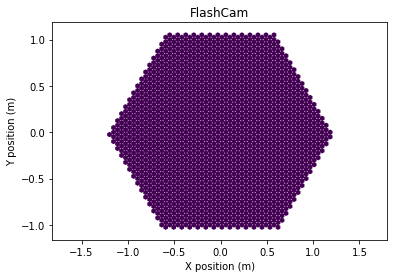

In [13]:
%matplotlib inline
from ctapipe.visualization import CameraDisplay
CameraDisplay(tel.camera)

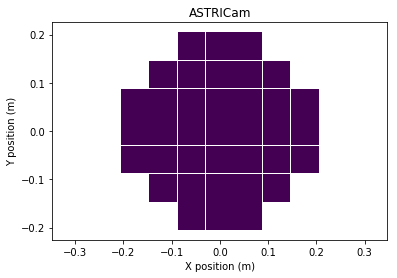

In [14]:
CameraDisplay(subarray.tel[98].camera)

## Plot the subarray

We'll make a subarray by telescope type and plot each separately, so they appear in different colors.  We also calculate the radius using the mirror area (and exagerate it a bit).

This is just for debugging and info, for any "real" use, a `visualization.ArrayDisplay` should be used

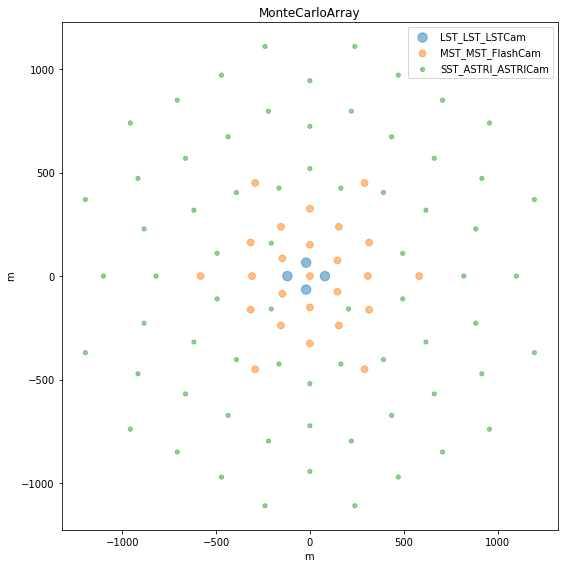

In [15]:
subarray.peek()

In [16]:
subarray.footprint

<Quantity 4.92354368 km2>

## Get info about the subarray in general

In [17]:
subarray.telescope_types

[TelescopeDescription(type=LST, name=LST, optics=LST, camera=LSTCam),
 TelescopeDescription(type=MST, name=MST, optics=MST, camera=FlashCam),
 TelescopeDescription(type=SST, name=ASTRI, optics=ASTRI, camera=ASTRICam)]

In [18]:
subarray.camera_types

[CameraGeometry(cam_id='LSTCam', pix_type='hexagonal', npix=1855, cam_rot=0.0 rad, pix_rot=100.89299992867878 deg),
 CameraGeometry(cam_id='FlashCam', pix_type='hexagonal', npix=1764, cam_rot=0.0 rad, pix_rot=0.0 deg),
 CameraGeometry(cam_id='ASTRICam', pix_type='rectangular', npix=2368, cam_rot=0.0 rad, pix_rot=0.0 deg)]

In [19]:
subarray.optics_types

[OpticsDescription(name=ASTRI, equivalent_focal_length=2.15 m, num_mirros=2, mirror_area=14.56 m2),
 OpticsDescription(name=MST, equivalent_focal_length=16.00 m, num_mirros=1, mirror_area=103.83 m2),
 OpticsDescription(name=LST, equivalent_focal_length=28.00 m, num_mirros=1, mirror_area=386.73 m2)]

In [33]:
from astropy.coordinates import SkyCoord
from ctapipe.coordinates import GroundFrame
center = SkyCoord("10.0 m", "2.0 m", "0.0 m", frame='groundframe')
coords = subarray.tel_coords  # a flat list of coordinates by tel_index
coords.separation(center)

<Angle [ 95.63833374, 117.59202028,  15.94236861, 166.40436814,
         90.        ,  78.71504671, 101.28495329,  16.32372666,
         38.71204146, 138.30730046, 160.75239071,  45.8365505 ,
         68.43595137,  11.45943212, 111.56404863, 134.1634495 ,
        168.54056788,  78.69548002, 101.30451998,  16.04005599,
         38.60912476, 141.39087524, 163.95994401,  45.81172359,
         68.42583965,  11.35210877, 111.57416035, 134.18827641,
        168.64789123,  49.03163391, 130.96836609, 153.57608224,
         57.48703137,  80.10529951,  99.89470049, 122.51296863,
          1.35549094,  23.85808087, 156.14191913, 178.64450906,
         78.69059764, 101.30940236,  34.56733094,  57.18536991,
        122.81463009, 145.43266906,  15.96593785,  38.58248153,
        141.41751847, 164.03406215,  78.69034114, 101.30965886,
         11.31525677, 168.68474323,  45.80312828,  68.42235035,
        111.57764965, 134.19687172,  63.2010615 ,  85.82047396,
         29.35930018,  51.97823035,   3.

## Telescope IDs vs Indices

Note that `subarray.tel` is a dict mapped by `tel_id` (the indentifying number of a telescope).  It is  possible to have telescope IDs that do not start at 0, are not contiguouous (e.g. if a subarray is selected).  Some functions and properties like `tel_coords` are numpy arrays (not dicts) so they are not mapped to the telescope ID, but rather the *index* within this SubarrayDescription. To convert between the two concepts you can do:

In [35]:
subarray.tel_ids_to_indices([1,5,23])

array([ 0,  4, 22])

or you can get the indexing array directly in numpy or dict form:

In [41]:
subarray.tel_index_array

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97])

In [40]:
subarray.tel_index_array[[1,5,23]]

array([ 0,  4, 22])

In [44]:
subarray.tel_indices[1]  # this is a dict of tel_id -> tel_index, so we can only do one at once

0

In [46]:
ids = subarray.get_tel_ids_for_type(subarray.telescope_types[0])
ids

[1, 2, 3, 4]

In [49]:
idx = subarray.tel_ids_to_indices(ids)
idx

array([0, 1, 2, 3])

In [50]:
subarray.tel_coords[idx]

<SkyCoord (GroundFrame): (x, y, z) in m
    [( -20.,  65., 16.), ( -20., -65., 16.), (  80.,   0., 16.),
     (-120.,   0., 16.)]>

so, with that method you can quickly get many telescope positions at once (the alternative is to use the dict `positions` which maps `tel_id` to a position on the ground

In [51]:
subarray.positions[1]

<Quantity [-20.,  65.,  16.] m>

## Manipulate the subarray With Pandas
If you prefer working with *Pandas* `DataFrames` instead of *AstroPy* `Tables`, you can always convert between the two:

In [ ]:
df = subarray.to_table().to_pandas()
df.set_index('tel_id')

In [ ]:
g = df.groupby('tel_description')
g.groups

In [ ]:
g.groups['LST_LST_LSTCam']

In [ ]:
df.loc[g.groups['LST_LST_LSTCam']]

In [ ]:
lsts = subarray.select_subarray("LSTs", df.loc[g.groups['LST:LSTCam']]['tel_id'])
lsts.info()
lsts.peek()
lsts.footprint